In [3]:
import pandas as pd

print(pd.read_csv('../output/pisa_ses_results.csv').head())
pd.read_csv('../output/tracking_age.csv').head()

  Country Subject       SES       Coef        SE
0     ESP    MATH      ESCS  32.325643  0.553436
1     ESP    MATH  PAREDINT   6.718253  0.189549
2     ESP    MATH     HISEI   1.092689  0.022805
3     ESP    READ      ESCS  30.542562  0.864474
4     ESP    READ  PAREDINT   6.694703  0.304785


,Country,tracking_age
0,Albania,15
1,United Arab Emirates,15
2,Argentina,15
3,Australia,No formal tracking
4,Austria,10


In [7]:
import pandas as pd

pisa_2022_country_map = {
    'ARE':'United Arab Emirates','ARG':'Argentina','AUS':'Australia','AUT':'Austria',
    'BEL':'Belgium','BGR':'Bulgaria','BRA':'Brazil','BRN':'Brunei Darussalam',
    'CAN':'Canada','CHE':'Switzerland','CHL':'Chile','COL':'Colombia','CRI':'Costa Rica',
    'CZE':'Czech Republic','DEU':'Germany','DNK':'Denmark','DOM':'Dominican Republic',
    'DZA':'Algeria','EGY':'Egypt','ESP':'Spain','EST':'Estonia','FIN':'Finland',
    'FRA':'France','GBR':'United Kingdom','GEO':'Georgia','GRC':'Greece',
    'HKG':'Hong Kong (China)','HRV':'Croatia','HUN':'Hungary','IDN':'Indonesia',
    'IRL':'Ireland','ISL':'Iceland','ISR':'Israel','ITA':'Italy','JPN':'Japan',
    'KAZ':'Kazakhstan','KOR':'Korea','LKA':'Sri Lanka','LTU':'Lithuania',
    'LVA':'Latvia','MYS':'Malaysia','MEX':'Mexico','MKD':'North Macedonia',
    'MLT':'Malta','MNE':'Montenegro','NLD':'Netherlands','NOR':'Norway',
    'NZL':'New Zealand','PER':'Peru','PHL':'Philippines','POL':'Poland',
    'PRT':'Portugal','QAT':'Qatar','ROU':'Romania','SAU':'Saudi Arabia','SGP':'Singapore',
    'SRB':'Serbia','SVK':'Slovak Republic','SVN':'Slovenia','SWE':'Sweden',
    'THA':'Thailand','TUN':'Tunisia','TUR':'Türkiye','UKR':'Ukraine','URY':'Uruguay',
    'USA':'United States','VNM':'Viet Nam'
}

country_lookup = pd.DataFrame([
    {'CNT': code, 'Country_Name': name}
    for code, name in pisa_2022_country_map.items()
])

In [13]:
import pandas as pd
from thefuzz import process

coef_df = pd.read_csv('../output/pisa_ses_results.csv')
track_df = pd.read_csv('../output/tracking_age.csv')


ses2 = coef_df.merge(country_lookup, left_on='Country', right_on='CNT', how='left')

ses2[['Country','Country_Name']].drop_duplicates()

,Country,Country_Name
0,ESP,Spain
9,KAZ,Kazakhstan
18,IDN,Indonesia
27,AUS,Australia
36,ITA,Italy
45,THA,Thailand
54,CZE,Czech Republic
63,BEL,Belgium
72,COL,Colombia
81,ROU,Romania


In [14]:
manual_fixes = {
    'UZB': 'Uzbekistan',
    'MAR': 'Morocco',
    'MDA': 'Moldova',
    'TAP': 'Timor-Leste',
    'KHM': 'Cambodia',
    'GTM': 'Guatemala',
    'PRY': 'Paraguay'
}

ses2['Country_Name'] = ses2.apply(
    lambda row: manual_fixes.get(row['Country'], row['Country_Name']),
    axis=1
)

In [16]:
from thefuzz import process

# Function to get best match from tracking_age
def match_country(name, choices):
    match, score = process.extractOne(name, choices)
    return match if score >= 80 else None  # threshold to avoid bad matches

track_choices = track_df['Country'].tolist()
ses2['Tracking_Country'] = ses2['Country_Name'].apply(lambda x: match_country(x, track_choices))

# Merge tracking age
ses_final = ses2.merge(track_df, left_on='Tracking_Country', right_on='Country', how='left')
ses_final = ses_final.drop(columns=['Country_y', 'Tracking_Country']).rename(columns={'Country_x':'Country'})

In [17]:
ses_final[['Country','Country_Name','tracking_age']]

,Country,Country_Name,tracking_age
0,ESP,Spain,16
1,ESP,Spain,16
2,ESP,Spain,16
3,ESP,Spain,16
4,ESP,Spain,16
...,...,...,...
346,PRY,Paraguay,15
347,PRY,Paraguay,15
348,PRY,Paraguay,15
349,PRY,Paraguay,15


In [26]:
# Filter to ESCS only
escs_df = ses_final[ses_final['SES'] == 'ESCS']
escs_df['tracking_age_num'] = pd.to_numeric(escs_df['tracking_age'], errors='coerce')
# Rows with "No formal tracking" become NaN

# Quick summary by country
escs_summary = escs_df.groupby(['Country', 'tracking_age_num'])['Coef'].mean().reset_index()
escs_summary.head()

/var/folders/b0/czsnk64s6wdcpxlyxxbmgxv80000gn/T/ipykernel_60415/3864795743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  escs_df['tracking_age_num'] = pd.to_numeric(escs_df['tracking_age'], errors='coerce')


,Country,tracking_age_num,Coef
0,AUT,10.0,46.476732
1,BEL,12.0,48.462152
2,BRN,12.0,39.507683
3,CHE,12.0,48.031015
4,COL,15.0,28.198753


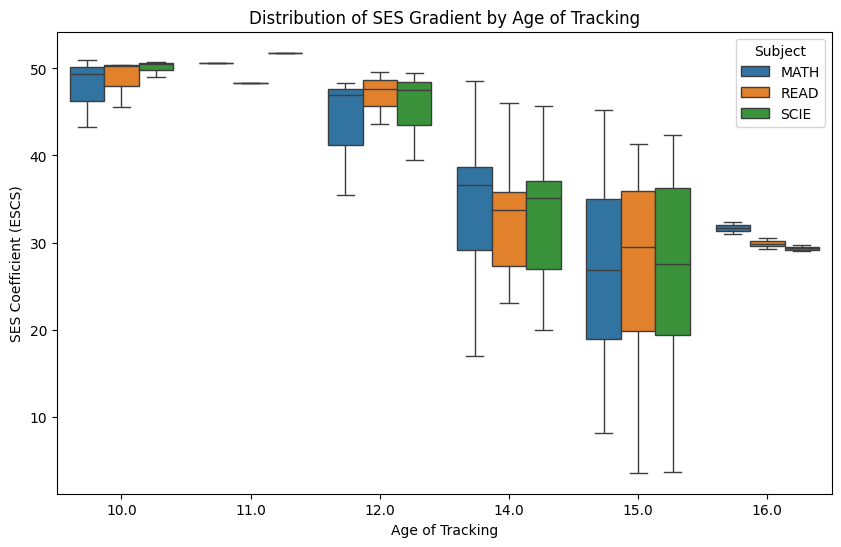

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=escs_df,
    x='tracking_age_num',
    y='Coef',
    hue='Subject'
)
plt.xlabel("Age of Tracking")
plt.ylabel("SES Coefficient (ESCS)")
plt.title("Distribution of SES Gradient by Age of Tracking")
plt.legend(title='Subject')
plt.show()

In [22]:
import statsmodels.formula.api as smf

model = smf.ols('Coef ~ tracking_age_num', data=escs_df[escs_df['Subject']=='MATH']).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Coef   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     18.03
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           0.000152
Time:                        09:46:11   Log-Likelihood:                -137.30
No. Observations:                  37   AIC:                             278.6
Df Residuals:                      35   BIC:                             281.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           93.6168     14.596  

<Figure size 1000x600 with 0 Axes>

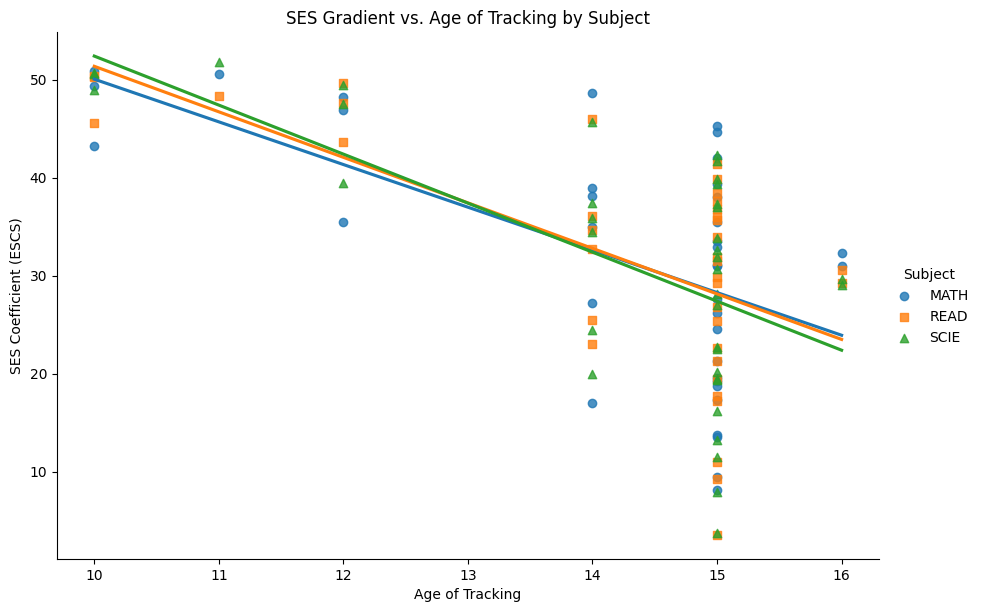

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter + regression lines, one color per subject
plt.figure(figsize=(10,6))
sns.lmplot(
    data=escs_df,
    x='tracking_age_num',
    y='Coef',
    hue='Subject',
    markers=['o','s','^'],
    height=6,
    aspect=1.5,
    ci=None
)
plt.xlabel("Age of Tracking")
plt.ylabel("SES Coefficient (ESCS)")
plt.title("SES Gradient vs. Age of Tracking by Subject")
plt.show()

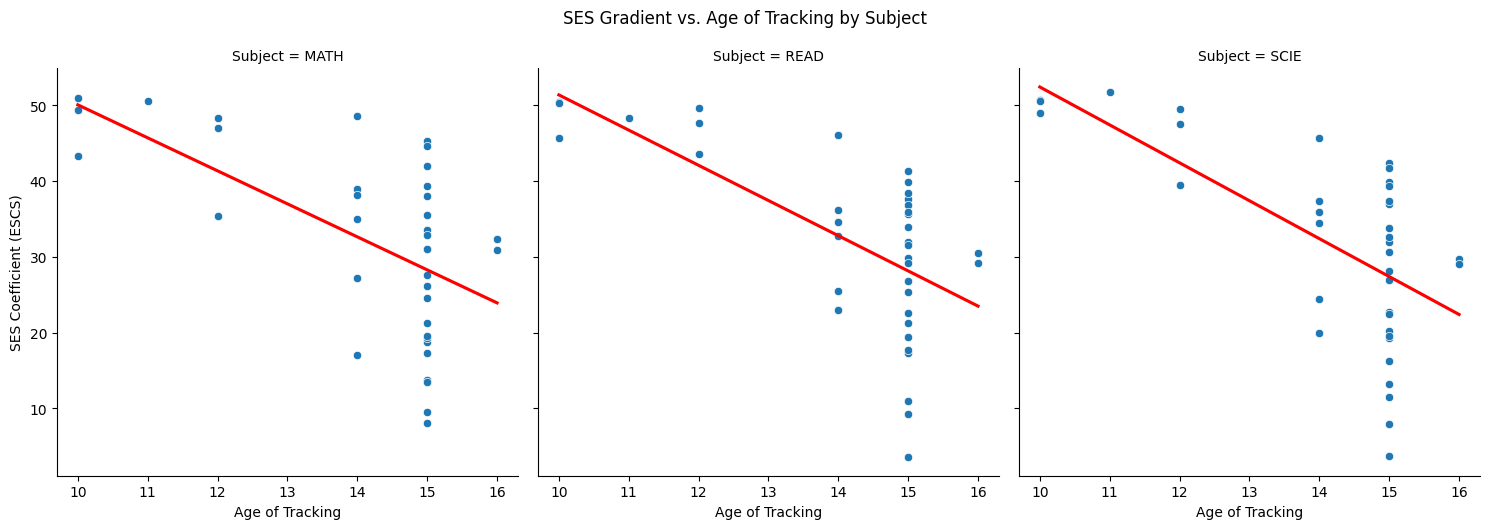

In [29]:
g = sns.FacetGrid(escs_df, col="Subject", height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="tracking_age_num", y="Coef")
g.map_dataframe(sns.regplot, x="tracking_age_num", y="Coef", scatter=False, ci=None, line_kws={"color":"red"})
g.set_axis_labels("Age of Tracking", "SES Coefficient (ESCS)")
g.fig.suptitle("SES Gradient vs. Age of Tracking by Subject", y=1.05)
plt.show()

In [31]:
import pandas as pd

# Save merged/cleaned dataframe
ses_final.to_csv('../output/pisa_ses_tracking_merged.csv', index=False)

# Reload for a clean session
merged_df = pd.read_csv('../output/pisa_ses_tracking_merged.csv')
print(merged_df.head())

  Country Subject       SES       Coef        SE  CNT Country_Name  \
0     ESP    MATH      ESCS  32.325643  0.553436  ESP        Spain   
1     ESP    MATH  PAREDINT   6.718253  0.189549  ESP        Spain   
2     ESP    MATH     HISEI   1.092689  0.022805  ESP        Spain   
3     ESP    READ      ESCS  30.542562  0.864474  ESP        Spain   
4     ESP    READ  PAREDINT   6.694703  0.304785  ESP        Spain   

  tracking_age  
0           16  
1           16  
2           16  
3           16  
4           16  
